# Imports

In [126]:
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('ticks')
sns.set_context('talk')
import pymc3 as pm

# Concept
With made up overly simple sea level data and GIA corrections, can we identify the 'real' GIA correction using the likelihood of the Bayesian model.

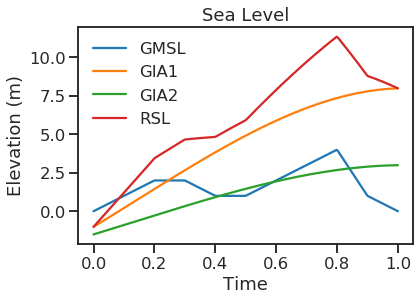

In [604]:
RESOLUTION = 200
TIME = np.linspace(0,1,RESOLUTION)
GMSL = [0,1,2,2,1,1,2,3,4,1,0]
GMSL = interp1d(np.linspace(0,1,len(GMSL)),GMSL)(TIME)
GIA1 = np.array([1,4,7,9,10])-2
GIA_fun1 = UnivariateSpline(np.linspace(0,1,len(GIA1)),GIA1,ext=1)
GIA2 = .5*np.array([1,4,7,9,10])-2
GIA_fun2 = UnivariateSpline(np.linspace(0,1,len(GIA2)),GIA2,ext=1)
RSL_fun = interp1d(np.linspace(0,1,len(GIA)),GIA_fun1(TIME)+GMSL)

plt.plot(TIME,GMSL,'-', label='GMSL')
plt.plot(TIME,GIA_fun1(TIME),'-', label='GIA1')
plt.plot(TIME,GIA_fun2(TIME),'-', label='GIA2')
plt.plot(TIME,RSL_fun(TIME),'-', label='RSL')

plt.legend(loc='best',frameon=False)
plt.gca().set_xlabel('Time')
plt.gca().set_ylabel('Elevation (m)')
_=plt.gca().set_title('Sea Level')

In [613]:
RSL_fun(np.array([.1,.15,.3,.5,.5,.8,.81,.84,.9,.9]))-interp1d(np.linspace(0,1,len(GMSL)),GMSL)(np.array([.1,.15,.3,.5,.5,.8,.81,.84,.9,.9]))

array([0.20800161, 0.82628541, 2.66170101, 4.91424964, 4.91424964,
       7.35595745, 7.40954931, 7.55738837, 7.79197242, 7.79197242])

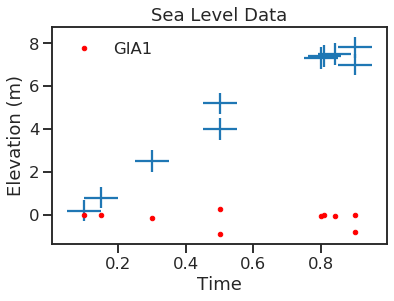

In [1039]:

data = {}
data["age"] = np.array([.1,.15,.3,.5,.5,.8,.81,.84,.9,.9])
data["age_uncertainty"] = np.array([0.05] * data["age"].size)
data["elevation"] = np.array([.2,.8,2.5,4,5.2,7.3,7.4,7.5,7.8,7.0])
data["elevation_uncertainty"] = np.array([0.5] * data["elevation"].size)

N=data['age'].size

plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",
)

GIA1 = GIA_fun1(data["age"])
GIA2 = np.array([0.208     , 0.82628571, 2.66171429, 3.91428571, 5.91428571,
       7.356     , 7.40959086, 7.55742629, 8.5    , 7.092     ])-.1

plt.plot(data["age"],data["elevation"]-GIA1,'r.',label='GIA1')
# plt.plot(data["age"],data["elevation"]-GIA2,'k.',zorder=3,label='GIA2')

plt.legend(loc='best',frameon=False)



plt.gca().set_xlabel('Time')
plt.gca().set_ylabel('Elevation (m)')
_=plt.gca().set_title('Sea Level Data')

In [1046]:
comparison = {}
for i in range(10):
    with pm.Model() as model:
        GIA = GIA1 + np.random.normal(0,.05,GIA1.size)

        sample_age = pm.Normal(
            "sample_age",
            mu=data["age"],
            sd=data["age_uncertainty"],
            shape=(N,)
        )

    #     sample_rsl = pm.Normal(
    #         "sample_rsl",
    #         mu=data["elevation"],
    #         sd=data["elevation_uncertainty"],
    #         shape=(N,)
    #     )

        #ls = pm.Gamma('ls',alpha=1,beta=1,shape=(2,1))  #lengthscale of cov for white noise and matern
        yls = pm.Gamma('constY',alpha=1,beta=1) #signal variance
    #   meany = pm.Normal('meanY',mu=0,sd=15) #mean of GMSL over interval

        cov = yls**2 * pm.gp.cov.WhiteNoise(1)

        gp = pm.gp.Latent(cov_func=cov)

        gmsl_inference = gp.prior(
            "gmsl", X=sample_age[:,np.newaxis], shape=((N),)
        )  # prior needs to be (n1+n2,)

        RSL_estimate = pm.Deterministic(
            "RSL_estimate", gmsl_inference.flatten() + GIA.flatten()
        )

        sigma = pm.HalfNormal('sigma',sd=15) #mean of GMSL over interval
        likelihood = pm.Normal(
            "zero",
            mu=RSL_estimate,
            sd=data["elevation_uncertainty"]+sigma,
            observed=data["elevation"]
        )

        #trace2 = pm.sample(draws=1000, tune=500, init='nuts', n_init=1000, progressbar=True)
        trace = pm.sample(progressbar=True)

        az_trace=az.convert_to_inference_data(trace)
        comparison[str(i)]=az_trace

i+=1       
with pm.Model() as model:
    GIA = data["elevation"] - 0 + np.random.normal(0,.05,GIA1.size)

    sample_age = pm.Normal(
        "sample_age",
        mu=data["age"],
        sd=data["age_uncertainty"],
        shape=(N,)
    )

#     sample_rsl = pm.Normal(
#         "sample_rsl",
#         mu=data["elevation"],
#         sd=data["elevation_uncertainty"],
#         shape=(N,)
#     )

    #ls = pm.Gamma('ls',alpha=1,beta=1,shape=(2,1))  #lengthscale of cov for white noise and matern
    yls = pm.Gamma('constY',alpha=1,beta=1) #signal variance
#   meany = pm.Normal('meanY',mu=0,sd=15) #mean of GMSL over interval

    cov = yls**2 * pm.gp.cov.WhiteNoise(1)

    gp = pm.gp.Latent(cov_func=cov)

    gmsl_inference = gp.prior(
        "gmsl", X=sample_age[:,np.newaxis], shape=((N),)
    )  # prior needs to be (n1+n2,)

    RSL_estimate = pm.Deterministic(
        "RSL_estimate", gmsl_inference.flatten() + GIA.flatten()
    )

    sigma = pm.HalfNormal('sigma',sd=15) #mean of GMSL over interval
    likelihood = pm.Normal(
        "zero",
        mu=RSL_estimate,
        sd=data["elevation_uncertainty"]+sigma,
        observed=data["elevation"]
    )

    #trace2 = pm.sample(draws=1000, tune=500, init='nuts', n_init=1000, progressbar=True)
    trace = pm.sample(progressbar=True)

    az_trace=az.convert_to_inference_data(trace)
    comparison[str(i)]=az_trace

#         gmsl_pred1 = gp.conditional("gmsl_pred",  TIME[:,None])
#         pred_samples1 = pm.sample_posterior_predictive(trace2, vars=[gmsl_pred1], samples=2000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gmsl_rotated_, constY, sample_age]
Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1129.34draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gmsl_rotated_, constY, sample_age]
Sampling 4 chains, 1 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1117.20draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gmsl_rotated_, constY, sample_age]
Sampling 4 chains, 0 divergences: 100%|██████████| 4000/4000 [00:03<00:00, 1185.21draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter

In [1047]:
comp = pm.compare(comparison, ic="waic", method="pseudo-BMA",
)
comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
10,0,-4.12076,0.280458,0,0.623725,0.0166507,0,False,log
0,1,-6.41752,0.672272,2.29677,0.0627365,0.916007,0.920771,False,log
8,2,-6.80827,0.684841,2.68752,0.0424444,1.03098,1.03595,False,log
2,3,-6.84533,0.700549,2.72458,0.0409002,1.05565,1.06015,False,log
5,4,-6.84763,0.745295,2.72688,0.0408062,1.11032,1.11473,False,log
1,5,-6.88954,0.766021,2.76879,0.0391313,1.05248,1.05726,False,log
3,6,-6.99182,0.747775,2.87106,0.0353271,1.12051,1.12531,False,log
9,7,-7.00288,0.76101,2.88212,0.0349385,1.15293,1.15796,False,log
4,8,-7.21252,0.79465,3.09176,0.0283307,1.1635,1.16831,False,log
7,9,-7.27138,0.871793,3.15062,0.0267114,1.19822,1.20265,False,log


In [1019]:
with pm.Model() as model2:
    GIA = GIA2
       
    sample_age = pm.Normal(
        "sample_age",
        mu=data["age"],
        sd=data["age_uncertainty"],
        shape=(N,)
    )

    sample_rsl = pm.Normal(
        "sample_rsl",
        mu=data["elevation"],
        sd=data["elevation_uncertainty"],
        shape=(N,)
    )

    #ls = pm.Gamma('ls',alpha=1,beta=1,shape=(2,1))  #lengthscale of cov for white noise and matern
    yls = pm.Gamma('constY',alpha=1,beta=1) #signal variance
#   meany = pm.Normal('meanY',mu=0,sd=15) #mean of GMSL over interval

    cov = yls**2 * pm.gp.cov.WhiteNoise(1)

    gp = pm.gp.Latent(cov_func=cov)
    
    gmsl_inference = gp.prior(
        "gmsl", X=sample_age[:,np.newaxis], shape=((N),)
    )  # prior needs to be (n1+n2,)

    RSL_estimate = pm.Deterministic(
        "RSL_estimate", gmsl_inference.flatten() + GIA.flatten()
    )

    sigma = pm.HalfNormal('sigma',sd=15) #mean of GMSL over interval
    likelihood = pm.Normal(
        "zero",
        mu=RSL_estimate,
        sd=data["elevation_uncertainty"]+sigma,
        observed=data["elevation"]
    )

    #trace2 = pm.sample(draws=1000, tune=500, init='nuts', n_init=1000, progressbar=True)
    trace2 = pm.sample(progressbar=True)
    
    az_trace2=az.convert_to_inference_data(trace2)
    
    gmsl_pred2 = gp.conditional("gmsl_pred",  TIME[:,None])
    pred_samples2 = pm.sample_posterior_predictive(trace2, vars=[gmsl_pred2], samples=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, gmsl_rotated_, constY, sample_rsl, sample_age]
100%|██████████| 2000/2000 [00:07<00:00, 273.93it/s]


In [1024]:
comp = pm.compare(
    {"model1": az_trace1, "model2": az_trace2,}, ic="waic", method="pseudo-BMA",
)
comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model2,0,-5.57351,0.47603,0,0.798602,0.618283,0,False,log
model1,1,-6.95109,0.784107,1.37758,0.201398,1.12932,1.37959,False,log


(0, 1)

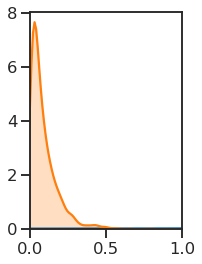

In [1021]:
plt.subplot(1,2,1)
sns.kdeplot([sigma.random() for i in range(1000)])
sns.kdeplot(trace2['sigma'],shade=True)
plt.gca().set_xlim(0,1)



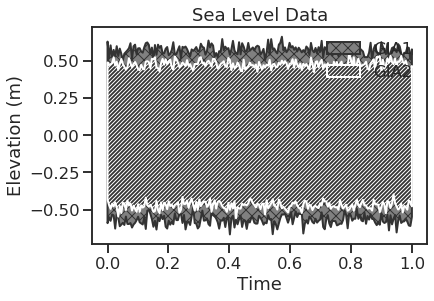

In [1028]:
percent = 5
top = np.percentile(pred_samples1['gmsl_pred'],100-(percent/2),axis=0)
bot = np.percentile(pred_samples1['gmsl_pred'],(percent/2),axis=0)
plt.fill_between(TIME,bot,top,alpha=1,facecolor=(.5,.5,.5,.5),hatch='\/\/',label='GIA1',lw=2,edgecolor=(.2,.2,.2))

top = np.nanpercentile(pred_samples2['gmsl_pred'],100-(percent/2),axis=0)
bot = np.nanpercentile(pred_samples2['gmsl_pred'],(percent/2),axis=0)
plt.fill_between(TIME,bot,top,alpha=1,facecolor=(.2,.2,.2,0),hatch='//////',label='GIA2',lw=2)
plt.legend(loc='best',frameon=False)



#plt.gca().set_ylim([-4,4])
plt.gca().set_xlabel('Time')
plt.gca().set_ylabel('Elevation (m)')
_=plt.gca().set_title('Sea Level Data')

In [741]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel as C,
    Matern,
    WhiteKernel,
)

In [931]:
sample_rsl = gp + gia

-13.115899821444824
4.89**2 * Matern(length_scale=1.17, nu=1.5) + WhiteKernel(noise_level=1e-05) + 0.337**2 * Matern(length_scale=0.00204, nu=1.5) + WhiteKernel(noise_level=1e-05)


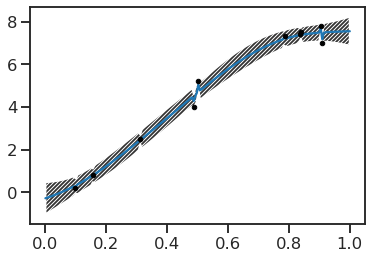

In [983]:

# X_stack = np.vstack([data['age'], data['elevation']]).T

kernel =  C(1) * Matern(
    length_scale=0.1, length_scale_bounds=(0.001, 100), nu=3 / 2
) + WhiteKernel(1) + C(1) * Matern(
    length_scale=0.1, length_scale_bounds=(0.001, 100), nu=3 / 2
) + WhiteKernel(1)  # covariance kernel for GP

X=np.atleast_2d(data['age']+np.random.normal(0,0.01,data['age'].size)).T
y=np.array(data['elevation']).ravel()

gp = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=150,
    alpha=.05,
)  # alpha is the variance added to the covariance matrix
gp.fit(X,y)  # fit the GP

y_pred, STD = gp.predict(TIME.reshape(-1, 1), return_std=True)
top=(y_pred.ravel()+STD.ravel())
bot=(y_pred.ravel()-STD.ravel())
plt.fill_between(TIME,bot,top,alpha=1,facecolor=(.2,.2,.2,0),hatch='//////',label='GIA2',lw=2)
plt.plot(TIME,y_pred)

plt.plot(X, y,'k.')

# x_test = np.vstack([GRID[0].ravel(), GRID[1].ravel()]).T
print(gp.log_marginal_likelihood_value_)
print(gp.kernel_)

# kernel = C(1) * Matern(
#     length_scale=0.1, length_scale_bounds=(0.001, 100), nu=3 / 2
# ) 

# gp = GaussianProcessRegressor(
#     kernel=kernel,
#     n_restarts_optimizer=150,
#     alpha=.1*data['elevation_uncertainty']**2,
# )  # alpha is the variance added to the covariance matrix
# gp.fit(data['age'].T.reshape(-1, 1), np.array(data['elevation']-GIA2).ravel())  # fit the GP

# y_pred, STD = gp.predict(TIME.reshape(-1, 1), return_std=True)
# top=(y_pred.ravel()+STD.ravel())
# bot=(y_pred.ravel()-STD.ravel())
# plt.fill_between(TIME,bot,top,alpha=1,facecolor=(.2,.2,.2,0),hatch='++',label='GIA2',lw=2)


# # x_test = np.vstack([GRID[0].ravel(), GRID[1].ravel()]).T
# print(gp.log_marginal_likelihood_value_)
# print(gp.kernel_)

2.5773441713685195
29**2 * Matern(length_scale=100, nu=1.5) + 0.00316**2 * WhiteKernel(noise_level=1e-05)


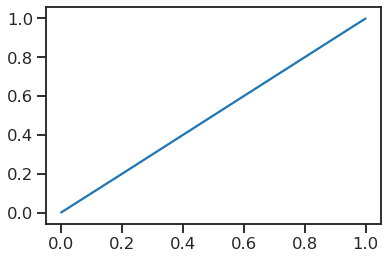

In [815]:

# X_stack = np.vstack([data['age'], data['elevation']]).T

kernel = C(1) * Matern(
    length_scale=0.1, length_scale_bounds=(0.001, 100), nu=3 / 2
) + C(1) * WhiteKernel(1)  # covariance kernel for GP

gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=15,
)  # alpha is the variance added to the covariance matrix
gp.fit(np.array([.2,.4,.6,.8]).T.reshape(-1, 1), np.array([.2,.4,.6,.8]).ravel())  # fit the GP

y_pred, STD = gp.predict(TIME.reshape(-1, 1), return_std=True)
top=(y_pred.ravel()+STD.ravel())
bot=(y_pred.ravel()-STD.ravel())
plt.fill_between(TIME,bot,top,alpha=1,facecolor=(.2,.2,.2,0),hatch='//////',label='GIA2',lw=2)
plt.plot(TIME,y_pred.ravel())

# x_test = np.vstack([GRID[0].ravel(), GRID[1].ravel()]).T
print(gp.log_marginal_likelihood_value_)
print(gp.kernel_)

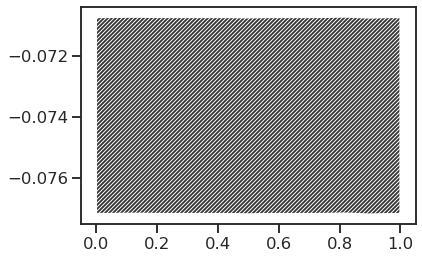

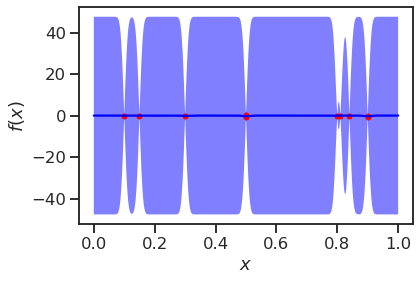

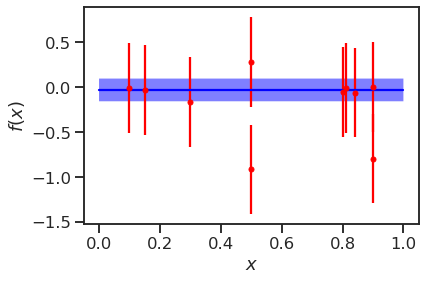

In [960]:
# Author: Vincent Dubourg <vincent.dubourg@gmail.com>
#         Jake Vanderplas <vanderplas@astro.washington.edu>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>s
# License: BSD 3 clause

import numpy as np
from matplotlib import pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

np.random.seed(1)


def f(x):
    """The function to predict."""
    return x * np.sin(x)

# ----------------------------------------------------------------------
#  First the noiseless case
X=np.atleast_2d(data['age']).T
y=np.array(data['elevation']-GIA1).ravel()

# Mesh the input space for evaluations of the real function, the prediction and
# its MSE
x = np.atleast_2d(np.linspace(0, 1, 1000)).T

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.plot(X, y, 'r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')



# ----------------------------------------------------------------------
# now the noisy case
X=np.atleast_2d(data['age']).T
y=np.array(data['elevation']-GIA1).ravel()

dy = data['elevation_uncertainty'].ravel()


# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=dy ** 2,
                              n_restarts_optimizer=10)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(x, return_std=True)

# Plot the function, the prediction and the 95% confidence interval based on
# the MSE
plt.figure()
plt.errorbar(X.ravel(), y, dy, fmt='r.', markersize=10, label='Observations')
plt.plot(x, y_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x, x[::-1]]),
         np.concatenate([y_pred - 1.9600 * sigma,
                        (y_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')


plt.show()

In [173]:
import warnings

warnings.filterwarnings("ignore")

with pm.Model() as model:
    scale=10
    ls = pm.Gamma(
        "x_lengthscale", alpha=1, beta=1, shape=(2, 1)
    )  # lengthscale of cov for white noise and matern
    yls = pm.Gamma("y_variance", alpha=1, beta=1)  # signal variance
    meany = pm.Normal("y_mean", mu=0, sd=15)  # mean of GMSL over interval
    cov = yls * pm.gp.cov.Matern32(1, ls=ls[0]/scale) + ls[1]/scale * pm.gp.cov.WhiteNoise(1)
    mean_func = pm.gp.mean.Constant(meany)
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)

    sample_age = pm.Normal(
        "sample_age",
        mu=data["age"][:, np.newaxis],
        sd=data["age_uncertainty"][:, np.newaxis],
        shape=(N, 1),
    )
    sample_rsl = pm.Normal(
        "sample_rsl",
        mu=data["elevation"][:, np.newaxis],
        sd=data["elevation_uncertainty"][:, np.newaxis],
        shape=(N, 1),
    )
    gia_spline = SplineWrapper(GIA_fun)
    gia_model = pm.Deterministic("gia", gia_spline(sample_age))

    gmsl_inference = gp.prior(
        "gmsl", X=sample_age, shape=(N,)
    )  # prior needs to be (n1+n2,)
   
    RSL_estimate = pm.Deterministic("RSL_estimate", gmsl_inference + gia_model)

    likelihood = pm.Normal("zero", mu=RSL_estimate, sd=data["elevation_uncertainty"], observed=data['elevation'])

    trace = pm.sample(
        draws=250,
        tune=250,
        step=pm.NUTS(target_accept=0.99),
        init="advi",
        cores=16,
        progressbar=True,
        chains=16,
    )

    gmsl_pred = gp.conditional("gmsl_pred",  TIME[:,None])
    pred_samples = pm.sample_posterior_predictive(trace, vars=[gmsl_pred], samples=2000)
    
warnings.resetwarnings()

Only 250 samples in chain.
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [gmsl_rotated_, sample_rsl, sample_age, y_mean, y_variance, x_lengthscale]
Sampling 16 chains, 0 divergences: 100%|██████████| 8000/8000 [02:52<00:00, 46.43draws/s]  
The acceptance probability does not match the target. It is 0.9593001330899109, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the target. It is 0.9395270706958653, but should be close to 0.99. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached

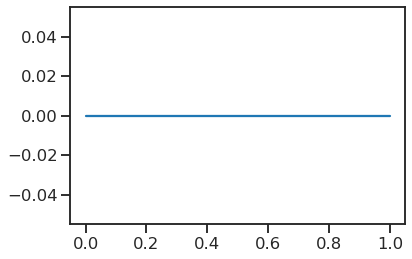

In [154]:
trace.varnames

['x_lengthscale_log__',
 'y_variance_log__',
 'y_mean',
 'sample_age',
 'sample_rsl',
 'gmsl_rotated_',
 'x_lengthscale',
 'y_variance',
 'gia',
 'gmsl',
 'residual']

In [130]:
with model:
    gmsl_pred = gp.conditional("gmsl_pred", TIME[:,None])
    pred_samples = pm.sample_posterior_predictive(trace, vars=[gmsl_pred], samples=2000)

/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/pymc3/sampling.py:1247: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "
  0%|          | 0/2000 [00:00<?, ?it/s]/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the futu

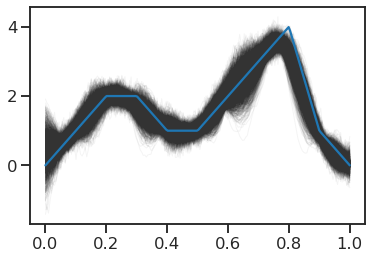

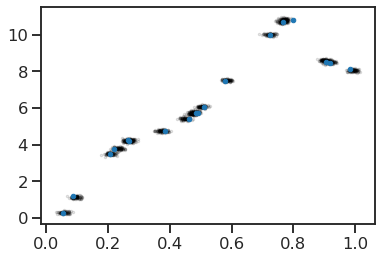

In [347]:
for i in range(100):
    plt.plot(sample_age.random(),sample_rsl.random(),'.',alpha=.1,color='k',markersize=5)
    
plt.plot(trace['sample_age'][0],trace['sample_rsl'][0],'.')

In [209]:
trace['sample_age'].shape

(18, 1)

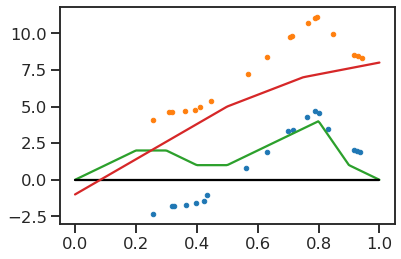

In [204]:
plt.plot(sample_age.random(),trace['gmsl'][0],'.')
plt.plot(data['age'],data['elevation'],'.')
plt.plot(TIME,GMSL)
plt.plot(TIME,RSL_fun(TIME)-GMSL-GIA,color='k')
plt.plot(TIME,GIA)

In [465]:
with pm.Model() as model2:
    GIA = np.array([1,4,4,4,3])-2
    GIA_fun = UnivariateSpline(np.linspace(0,1,len(GIA)),GIA,ext=1)

    
    sample_age = pm.Normal(
        "sample_age",
        mu=data["age"],
        sd=data["age_uncertainty"],
        shape=(N,)
    )

    sample_rsl = pm.Normal(
        "sample_rsl",
        mu=data["elevation"],
        sd=data["elevation_uncertainty"],
        shape=(N,)
    )

    gia_spline = SplineWrapper(GIA_fun)
    gia_model = pm.Deterministic("gia", gia_spline(sample_age))

    noise_sd = pm.HalfNormal("noise_sd", sd=1, shape=(N, 1))

#     gmsl_inference = pm.Normal(
#         "gmsl", mu=np.zeros(N)[:, np.newaxis], sd=noise_sd, shape=(N, 1)
#     )  # prior needs to be (n1+n2,)
    
    scale=10
    ls = pm.Gamma(
        "x_lengthscale", alpha=1, beta=1, shape=(2, 1)
    )  # lengthscale of cov for white noise and matern
    yls = pm.Gamma("y_variance", alpha=1, beta=1)  # signal variance
    meany = pm.Normal("y_mean", mu=0, sd=15)  # mean of GMSL over interval
    cov = yls * pm.gp.cov.Matern32(1, ls=ls[0]/scale) + ls[1]/scale * pm.gp.cov.WhiteNoise(1)
    mean_func = pm.gp.mean.Constant(meany)
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)
    gmsl_inference = gp.prior(
        "gmsl", X=sample_age[:,np.newaxis], shape=((N),)
    )  # prior needs to be (n1+n2,)

    RSL_estimate = pm.Deterministic(
        "RSL_estimate", gmsl_inference.flatten() + gia_model.flatten()
    )

    likelihood = pm.Normal(
        "zero",
        mu=RSL_estimate,
        sd=data["elevation_uncertainty"],
        observed=data["elevation"]
    )

    trace2 = pm.sample(draws=1000, tune=500, init='nuts', n_init=1000, progressbar=True)
    
#     gmsl_pred = gp.conditional("gmsl_pred",  TIME[:,None])
#     pred_samples = pm.sample_posterior_predictive(trace2, vars=[gmsl_pred], samples=2000)

warnings.resetwarnings()

/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gmsl_rotated_, y_mean, y_variance, x_lengthscale, noise_sd, sample_rsl, sample_age]
Sampling 4 chains, 77 divergences: 100%|██████████| 6000/6000 [06:41<00:00, 14.93draws/s]
/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/arviz/data/io_pymc3.py:98: PendingDeprecationWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call fr

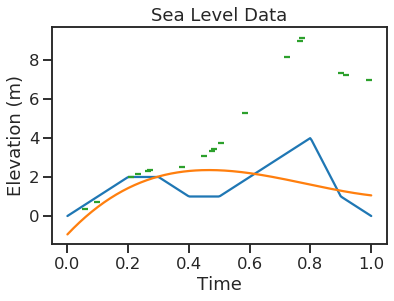

In [468]:
# for i in range(2000):
#     plt.plot(TIME,pred_samples['gmsl_pred'][i],lw=1,alpha=.05,color=(.2,.2,.2))
plt.plot(TIME,GMSL)
plt.plot(TIME,GIA_fun(TIME))

plt.errorbar(
    data["age"],
    data["elevation"]-GIA_fun(data['age']),
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",zorder=10,
)
plt.gca().set_xlabel('Time')
plt.gca().set_ylabel('Elevation (m)')
_=plt.gca().set_title('Sea Level Data')

In [374]:
warnings.filterwarnings("ignore")

with pm.Model() as model1:
    GIA = np.array([1,4,7,9,10])-2
    GIA_fun = UnivariateSpline(np.linspace(0,1,len(GIA)),GIA,ext=1)

    
    sample_age = pm.Normal(
        "sample_age",
        mu=data["age"],
        sd=data["age_uncertainty"],
        shape=(N,)
    )

    sample_rsl = pm.Normal(
        "sample_rsl",
        mu=data["elevation"],
        sd=data["elevation_uncertainty"],
        shape=(N,)
    )

    gia_spline = SplineWrapper(GIA_fun)
    gia_model = pm.Deterministic("gia", gia_spline(sample_age))
    
    scale=10
    ls = pm.Gamma(
        "x_lengthscale", alpha=1, beta=1, shape=(2, 1)
    )  # lengthscale of cov for white noise and matern
    yls = pm.Gamma("y_variance", alpha=1, beta=1)  # signal variance
    meany = pm.Normal("y_mean", mu=0, sd=15)  # mean of GMSL over interval
    cov = yls * pm.gp.cov.Matern32(1, ls=ls[0]/scale) + ls[1]/scale * pm.gp.cov.WhiteNoise(1)
    mean_func = pm.gp.mean.Constant(meany)
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)
    gmsl_inference = gp.prior(
        "gmsl", X=sample_age[:,np.newaxis], shape=((N),)
    )  # prior needs to be (n1+n2,)

    RSL_estimate = pm.Deterministic(
        "RSL_estimate", gmsl_inference.flatten() + gia_model.flatten()
    )

    likelihood = pm.Normal(
        "zero",
        mu=RSL_estimate,
        sd=data["elevation_uncertainty"],
        observed=data["elevation"]
    )

    trace1 = pm.sample(draws=1000, tune=500, init='nuts', n_init=1000, progressbar=True)
    
#     gmsl_pred = gp.conditional("gmsl_pred",  TIME[:,None])
#     pred_samples = pm.sample_posterior_predictive(trace1, vars=[gmsl_pred], samples=2000)

warnings.resetwarnings()

Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gmsl_rotated_, y_mean, y_variance, x_lengthscale, noise_sd, sample_rsl, sample_age]
Sampling 4 chains, 1,826 divergences: 100%|██████████| 6000/6000 [02:59<00:00, 33.39draws/s]
There were 440 divergences after tuning. Increase `target_accept` or reparameterize.
There were 425 divergences after tuning. Increase `target_accept` or reparameterize.
There were 459 divergences after tuning. Increase `target_accept` or reparameterize.
There were 500 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gmsl_rotated_, y_mean, y_variance, x_lengthscale, noise_sd, sample_rsl, sample_age]
Sampling 4 chains, 3,401 divergences: 100%|██████████| 6000/6000 [05:23<00:00, 18.57draws/s] 
The chain contains only diverging samples. The model is probably miss

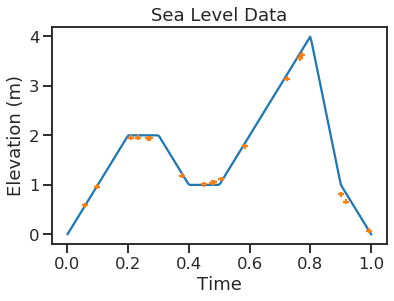

In [463]:
# for i in range(2000):
#     plt.plot(TIME,pred_samples['gmsl_pred'][i],lw=1,alpha=.05,color=(.2,.2,.2))
plt.plot(TIME,GMSL)

plt.errorbar(
    data["age"],
    data["elevation"]-GIA_fun(data['age']),
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",zorder=10,
)
plt.gca().set_xlabel('Time')
plt.gca().set_ylabel('Elevation (m)')
_=plt.gca().set_title('Sea Level Data')


bayesian vs freq model selection:
> https://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/

model averaging

> https://docs.pymc.io/notebooks/model_averaging.html

What makes a model better?
The observed sea level should match when corrected for GIA. Will this 'matching' show up in the marginal likelihood of the GP?
Imagine two datapoints with the same age, but 2 meters apart.
Another GIA model brings those two datapoints together.
Will the marginal likelihood of the second model be better than the first?

In [469]:
# traces=[trace1,trace2]
# model_dict = dict(zip([model1, model2], traces))
comp = pm.stats.compare({model1: trace1, model2: trace2})
comp

/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/arviz/data/io_pymc3.py:98: PendingDeprecationWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  PendingDeprecationWarning,
/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/arviz/stats/stats.py:532: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
<pymc3.model.Model object at 0x7fdb57ab52d0>,0,-21605.1,17701.6,0,NaN,151.952,0,True,log
<pymc3.model.Model object at 0x7fdb58434310>,1,-25874.1,7192.61,4269.01,0,165.851,222.919,True,log


In [389]:
J = 8
y = np.array([28,  8, -3,  7, -1,  1, 18, 12])
sigma = np.array([15, 10, 16, 11,  9, 11, 10, 18])

with pm.Model() as pooled:
    mu = pm.Normal('mu', 0, sigma=1e6)

    obs = pm.Normal('obs', mu, sigma=sigma, observed=y)

    trace_p = pm.sample(1000)
    
with pm.Model() as hierarchical:

    eta = pm.Normal('eta', 0, 1, shape=J)
    mu = pm.Normal('mu', 0, sigma=1e6)
    tau = pm.HalfCauchy('tau', 5)

    theta = pm.Deterministic('theta', mu + tau*eta)

    obs = pm.Normal('obs', theta, sigma=sigma, observed=y)

    trace_h = pm.sample(1000)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains, 0 divergences: 100%|██████████| 6000/6000 [00:00<00:00, 10712.39draws/s]
/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/arviz/data/io_pymc3.py:98: PendingDeprecationWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  PendingDeprecationWarning,
/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/arviz/data/io_pymc3.py:98: PendingDeprecationWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  PendingDeprecationWarning,
Auto-assigning NUTS sa

In [393]:
df_comp_WAIC = pm.compare({hierarchical: trace_h, pooled: trace_p})
df_comp_WAIC

/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/arviz/data/io_pymc3.py:98: PendingDeprecationWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  PendingDeprecationWarning,


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
<pymc3.model.Model object at 0x7fdb65acea10>,0,-30.5404,0.659433,0,0.548378,0.939191,0,False,log
<pymc3.model.Model object at 0x7fdb65ace210>,1,-30.7357,1.03596,0.19531,0.451622,1.0312,0.116499,False,log


In [409]:
trace_h.varnames

['eta', 'mu', 'tau_log__', 'tau', 'theta']

In [399]:
import arviz as az

az.compare({'1':az.convert_to_inference_data(trace1),'2':az.convert_to_inference_data(trace2)})

TypeError: log likelihood not found in inference data object

In [428]:
A=az.convert_to_inference_data(trace1, model=model1)
az.waic(A)

TypeError: log likelihood not found in inference data object

In [454]:
model.observed_RVs[0]

zero

In [453]:
model.observed_RVs[0].logp_elemwise()

TypeError: Missing required input: sample_age

In [449]:
model.observed_RVs[0].logp_elemwise([trace['sample_age'],trace['sample_rsl']])

TypeError: can't turn [[array([[0.91784486, 0.79704821, 0.26874419, ..., 0.2191922 , 0.7660023 ,
        0.20698176],
       [0.92159993, 0.78487086, 0.26418269, ..., 0.22860972, 0.78095031,
        0.2136886 ],
       [0.92434508, 0.79482944, 0.27142419, ..., 0.21434356, 0.76354378,
        0.19654158],
       ...,
       [0.90624606, 0.76252217, 0.25868621, ..., 0.23129025, 0.75045391,
        0.2136061 ],
       [0.90027393, 0.76232208, 0.25475255, ..., 0.23233645, 0.75397517,
        0.21324057],
       [0.89864451, 0.76205901, 0.25437876, ..., 0.229693  , 0.75166195,
        0.21175571]]), array([[ 8.47440801, 10.8147049 ,  4.21956274, ...,  3.78620476,
        10.70789664,  3.48670282],
       [ 8.46187513, 10.82815355,  4.23816345, ...,  3.80313565,
        10.71865734,  3.48000474],
       [ 8.47686272, 10.87366312,  4.28364944, ...,  3.82588179,
        10.71040308,  3.47354386],
       ...,
       [ 8.45348023, 10.87064747,  4.21930112, ...,  3.86076001,
        10.65629751,  3.4270312 ],
       [ 8.469193  , 10.89807739,  4.22292089, ...,  3.84294848,
        10.65227706,  3.43532867],
       [ 8.46886807, 10.89982695,  4.22680309, ...,  3.84232992,
        10.65206502,  3.43630495]])]] and {} into a dict. dictionary update sequence element #0 has length 4000; 2 is required

In [418]:
az.convert_to_inference_data(pred_samples, log_likelihood=['gmsl_pred'])

Inference data with groups:
	> posterior

TypeError: waic() got an unexpected keyword argument 'log_likelihood'

In [403]:
A.posterior

<xarray.Dataset>
Dimensions:              (RSL_estimate_dim_0: 18, chain: 4, draw: 1000, gia_dim_0: 18, gmsl_dim_0: 18, gmsl_rotated__dim_0: 18, noise_sd_dim_0: 18, noise_sd_dim_1: 1, sample_age_dim_0: 18, sample_rsl_dim_0: 18, x_lengthscale_dim_0: 2, x_lengthscale_dim_1: 1)
Coordinates:
  * chain                (chain) int64 0 1 2 3
  * draw                 (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * sample_age_dim_0     (sample_age_dim_0) int64 0 1 2 3 4 5 ... 13 14 15 16 17
  * sample_rsl_dim_0     (sample_rsl_dim_0) int64 0 1 2 3 4 5 ... 13 14 15 16 17
  * gmsl_rotated__dim_0  (gmsl_rotated__dim_0) int64 0 1 2 3 4 ... 14 15 16 17
  * gia_dim_0            (gia_dim_0) int64 0 1 2 3 4 5 6 ... 12 13 14 15 16 17
  * noise_sd_dim_0       (noise_sd_dim_0) int64 0 1 2 3 4 5 ... 13 14 15 16 17
  * noise_sd_dim_1       (noise_sd_dim_1) int64 0
  * x_lengthscale_dim_0  (x_lengthscale_dim_0) int64 0 1
  * x_lengthscale_dim_1  (x_lengthscale_dim_1) int64 0
  * gmsl_dim_0           (gmsl_dim_0) int64 0 1 2 3 4 5 6 ... 12 13 14 15 16 17
  * RSL_estimate_dim_0   (RSL_estimate_dim_0) int64 0 1 2 3 4 ... 13 14 15 16 17
Data variables:
    sample_age           (chain, draw, sample_age_dim_0) float64 0.9124 ... 0.1994
    sample_rsl           (chain, draw, sample_rsl_dim_0) float64 8.471 ... 3.409
    y_mean               (chain, draw) float64 0.5118 0.5121 ... 1.547 1.555
    gmsl_rotated_        (chain, draw, gmsl_rotated__dim_0) float64 0.2556 ... -0.5867
    gia                  (chain, draw, gia_dim_0) float64 7.83 7.222 ... 1.437
    noise_sd             (chain, draw, noise_sd_dim_0, noise_sd_dim_1) float64 0.856 ... 0.7579
    x_lengthscale        (chain, draw, x_lengthscale_dim_0, x_lengthscale_dim_1) float64 1.613 ... 0.001911
    y_variance           (chain, draw) float64 0.814 0.8134 ... 1.632 1.611
    gmsl                 (chain, draw, gmsl_dim_0) float64 0.7434 ... 1.935
    RSL_estimate         (chain, draw, RSL_estimate_dim_0) float64 8.573 ... 3.372
Attributes:
    created_at:                 2020-05-06T22:52:14.200153
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.8

In [365]:

model_dict = dict(zip([model_0, model_1, model_2], traces))
comp = pm.compare(model_dict, method='BB-pseudo-BMA')



/home/blake/anaconda3/envs/jupyterbase/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


TypeError: __call__() missing 1 required positional argument: 'x'

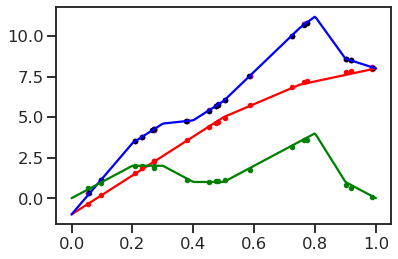

In [346]:
plt.plot(np.mean(trace['sample_age'],axis=0),np.mean(trace['sample_rsl'],axis=0),'b.')
plt.plot(np.mean(trace['sample_age'],axis=0),np.mean(trace['gmsl'],axis=0),'g.')
plt.plot(np.mean(trace['sample_age'],axis=0),np.mean(trace['gia'],axis=0),'r.')
plt.plot(np.mean(trace['sample_age'],axis=0),np.mean(trace['RSL_estimate'],axis=0),'m.')


plt.plot(data["age"],data["elevation"],'k.')
# plt.plot(data["age"],np.mean(trace['gmsl'],axis=0),'g.')
# plt.plot(data["age"],np.mean(trace['gia'],axis=0),'r.')
# plt.plot(data["age"],np.mean(trace['RSL_estimate'],axis=0),'m.')


plt.plot(TIME,GIA,'r')
plt.plot(TIME,RSL_fun(TIME),'b')
plt.plot(TIME,GMSL,'g')


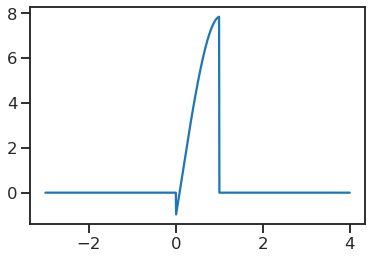

# GIA model comparisons

What makes a model better?
The observed sea level should match when corrected for GIA. Will this 'matching' show up in the marginal likelihood of the GP?
Imagine two datapoints with the same age, but 2 meters apart.
Another GIA model brings those two datapoints together.
Will the marginal likelihood of the second model be better than the first?

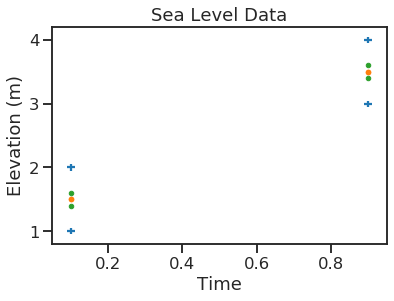

In [581]:
RSL = np.array([1,2,3,4])
GIA1 = np.array([.5,-.5,.5,-.5])
GIA2 = np.array([.6,-.6,.4,-.4])
AGE = np.array([0.1,0.1,.9,.9])

N = 4
data = {}
data["age"] = AGE
data["age_uncertainty"] = np.array([0.01] * data["age"].size)
data["elevation"] = RSL
data["elevation_uncertainty"] = np.array([0.05] * data["elevation"].size)

plt.errorbar(
    data["age"],
    data["elevation"],
    xerr=data["age_uncertainty"],
    yerr=data["elevation_uncertainty"],
    linestyle="none",
)
plt.plot(AGE,RSL+GIA1,'.')
plt.plot(AGE,RSL+GIA2,'.')
plt.gca().set_xlabel('Time')
plt.gca().set_ylabel('Elevation (m)')
_=plt.gca().set_title('Sea Level Data')

In [582]:
warnings.filterwarnings("ignore")

with pm.Model() as model1:
    GIA = GIA1
       
    sample_age = pm.Normal(
        "sample_age",
        mu=data["age"],
        sd=data["age_uncertainty"],
        shape=(N,)
    )

    sample_rsl = pm.Normal(
        "sample_rsl",
        mu=data["elevation"],
        sd=data["elevation_uncertainty"],
        shape=(N,)
    )

    scale=10
    ls = pm.Gamma(
        "x_lengthscale", alpha=1, beta=1, shape=(2, 1)
    )  # lengthscale of cov for white noise and matern
    yls = pm.Gamma("y_variance", alpha=1, beta=1)  # signal variance
    meany = pm.Normal("y_mean", mu=0, sd=15)  # mean of GMSL over interval
    cov = yls * pm.gp.cov.Matern32(1, ls=ls[0]/scale) + ls[1]/scale * pm.gp.cov.WhiteNoise(1)
    mean_func = pm.gp.mean.Constant(meany)
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)
    gmsl_inference = gp.prior(
        "gmsl", X=sample_age[:,np.newaxis], shape=((N),)
    )  # prior needs to be (n1+n2,)

    RSL_estimate = pm.Deterministic(
        "RSL_estimate", gmsl_inference.flatten() + GIA.flatten()
    )

    likelihood = pm.Normal(
        "zero",
        mu=RSL_estimate,
        sd=data["elevation_uncertainty"],
        observed=data["elevation"]
    )

    trace1 = pm.sample(draws=1000, tune=500, init='nuts', n_init=2000, progressbar=True)
    
    az_trace1=az.convert_to_inference_data(trace1)
    
    gmsl_pred1 = gp.conditional("gmsl_pred",  TIME[:,None])
    pred_samples1 = pm.sample_posterior_predictive(trace1, vars=[gmsl_pred1], samples=2000)

warnings.resetwarnings()

Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gmsl_rotated_, y_mean, y_variance, x_lengthscale, sample_rsl, sample_age]
Sampling 4 chains, 705 divergences: 100%|██████████| 12000/12000 [02:46<00:00, 72.19draws/s]
There were 73 divergences after tuning. Increase `target_accept` or reparameterize.
There were 409 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5681147942618805, but should be close to 0.8. Try to increase the number of tuning steps.
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
There were 125 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jo

In [583]:
warnings.filterwarnings("ignore")

with pm.Model() as model2:
    GIA = GIA2
       
    sample_age = pm.Normal(
        "sample_age",
        mu=data["age"],
        sd=data["age_uncertainty"],
        shape=(N,)
    )

    sample_rsl = pm.Normal(
        "sample_rsl",
        mu=data["elevation"],
        sd=data["elevation_uncertainty"],
        shape=(N,)
    )

    scale=10
    ls = pm.Normal(
        "white_noise", mu=0, sd=5
    )  # lengthscale of cov for white noise and matern
    yls = pm.Gamma("y_variance", alpha=1, beta=1)  # signal variance
    meany = pm.Normal("y_mean", mu=0, sd=15)  # mean of GMSL over interval
    cov = yls * pm.gp.cov.Matern32(1, ls=.1) + ls**2 * pm.gp.cov.WhiteNoise(1)
    mean_func = pm.gp.mean.Constant(meany)
    gp = pm.gp.Latent(mean_func=mean_func, cov_func=cov)
    gmsl_inference = gp.prior(
        "gmsl", X=sample_age[:,np.newaxis], shape=((N),)
    )  # prior needs to be (n1+n2,)

    RSL_estimate = pm.Deterministic(
        "RSL_estimate", gmsl_inference.flatten() + GIA.flatten()
    )

    likelihood = pm.Normal(
        "zero",
        mu=RSL_estimate,
        sd=data["elevation_uncertainty"],
        observed=data["elevation"]
    )

    trace2 = pm.sample(draws=1000, tune=500, init='nuts', n_init=2000, progressbar=True)
    
    az_trace2=az.convert_to_inference_data(trace2)
    
    gmsl_pred2 = gp.conditional("gmsl_pred",  TIME[:,None])
    pred_samples2 = pm.sample_posterior_predictive(trace2, vars=[gmsl_pred2], samples=2000)

warnings.resetwarnings()

Auto-assigning NUTS sampler...
Initializing NUTS using nuts...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gmsl_rotated_, y_mean, y_variance, x_lengthscale, sample_rsl, sample_age]
Sampling 4 chains, 360 divergences: 100%|██████████| 12000/12000 [02:50<00:00, 70.53draws/s]
There were 65 divergences after tuning. Increase `target_accept` or reparameterize.
There were 85 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7215898680328025, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [gmsl_rotated_, y_mean, y_variance, x_lengthscale, sample_rsl, sample_age]
Sampling 4 chains, 181 divergences

In [585]:
comp = pm.compare(
    {
        "model1": az_trace1,
        "model2": az_trace2,
    },ic='waic',
    method="pseudo-BMA",
)
comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
model1,0,-421920,420698,0,1,4406.06,0,True,log
model2,1,-2.03369e+06,2.03276e+06,1.61177e+06,0,6894.1,9446.46,True,log


model1 should be slightly better

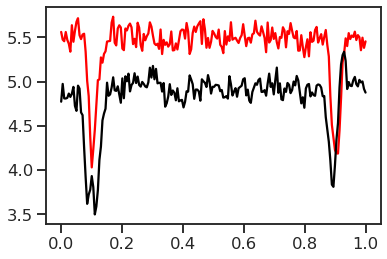

In [596]:
plt.plot(TIME,np.percentile(pred_samples1['gmsl_pred'],95,axis=0)-np.percentile(pred_samples1['gmsl_pred'],5,axis=0),'r')


plt.plot(TIME,np.percentile(pred_samples2['gmsl_pred'],95,axis=0)-np.percentile(pred_samples2['gmsl_pred'],5,axis=0),'k')


In [597]:
np.trapz(np.percentile(pred_samples2['gmsl_pred'],95,axis=0)-np.percentile(pred_samples2['gmsl_pred'],5,axis=0))


960.5661389221127

In [598]:
np.trapz(np.percentile(pred_samples1['gmsl_pred'],95,axis=0)-np.percentile(pred_samples1['gmsl_pred'],5,axis=0))

1076.9812160853799

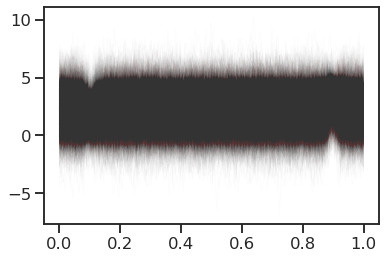

In [586]:
for i in range(2000):
    plt.plot(TIME,pred_samples1['gmsl_pred'][i],lw=1,alpha=.01,color=(.2,.2,.2))
    plt.plot(TIME,pred_samples2['gmsl_pred'][i],lw=1,alpha=.01,color=(.4,.2,.2))

In [499]:
 gmsl_pred = gp.conditional("gmsl_pred",  TIME[:,None])
#     pred_samples = pm.sample_posterior_predictive(trace1, vars=[gmsl_pred], samples=2000)

In [517]:
ppc_w = pm.sample_posterior_predictive_w([trace1,trace2], models=[model1, model2], vars=[gmsl_pred,], samples=1000, 
                        weights=[0,1],
                        progressbar=True)

TypeError: sample_posterior_predictive_w() got an unexpected keyword argument 'vars'

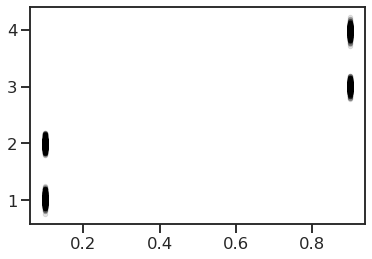

In [513]:
for i in range(1000):
    plt.plot(AGE,ppc_w['zero'][i,:],'.',color='k',alpha=.1)

In [511]:
comp.weight.sort_index(ascending=True)

model1    1
model2    0
Name: weight, dtype: object

In [519]:
pm.sample_posterior_predictive_w??

In [554]:
with model1:
#     gmsl_pred = gp.conditional("gmsl_pred",  TIME[:,None])
    pred_samples1 = pm.sample_posterior_predictive(trace1, vars=[RSL_estimate], samples=2000)

100%|██████████| 2000/2000 [00:01<00:00, 1101.54it/s]


In [555]:
pred_samples1

{'RSL_estimate': array([[0.74600846, 2.75134354, 2.74923682, 4.67153052],
        [0.75499414, 2.70587733, 2.7521739 , 4.57205925],
        [0.75521742, 2.69636992, 2.75916312, 4.66518578],
        ...,
        [0.63609294, 2.62104828, 2.84393921, 4.65241491],
        [0.68161648, 2.80197976, 2.87165437, 4.50957615],
        [0.6820831 , 2.68307793, 2.87283085, 4.67252379]])}

In [560]:
az.from_pymc3(trace1, model=model1, log_likelihood=['sample_rsl']).log_likelihood

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*
Attributes:
    created_at:                 2020-05-07T01:09:10.814431
    arviz_version:              0.7.0
    inference_library:          pymc3
    inference_library_version:  3.8

In [543]:
with model2:
#     gmsl_pred = gp.conditional("gmsl_pred",  TIME[:,None])
    pred_samples2 = pm.sample_posterior_predictive(trace1, vars=[gmsl_pred], samples=2000)

100%|██████████| 2000/2000 [00:21<00:00, 93.73it/s]


In [547]:
test = pm.compare(
    {
        "model1": az.from_pymc3(trace1, model=model1, log_likelihood=trace1),
        "model2": az.from_pymc3(trace2, model=model2, log_likelihood=trace2),
    },ic='waic',
    method="pseudo-BMA",
)
test

TypeError: log likelihood not found in inference data object

https://github.com/arviz-devs/arviz/issues/925#issuecomment-560014504

comment on how to make arbiz and posterior work nicely together

In [ ]:
gmsl + gia = obs
gmsl + gia - obs = 0

In [65]:
data["age_uncertainty"].shape

(8, 1)

In [85]:
data["age_uncertainty"]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [122]:
from pymc3.distributions.dist_math import SplineWrapper
import theano.tensor as tt
from theano.compile.ops import as_op



with pm.Model():
    sample_age = pm.Normal(
        "sample_age",
        mu=data["age"][:, np.newaxis],
        sd=data["age_uncertainty"][:, np.newaxis],
        shape=(N, 1),
    )
    sample_rsl = pm.Normal(
        "sample_rsl",
        mu=data["elevation"][:, np.newaxis],
        sd=data["elevation_uncertainty"][:, np.newaxis],
        shape=(N, 1),
    )
    gia_spline = SplineWrapper(GIA_fun)
    gia_model = pm.Deterministic("gia", gia_spline(sample_age))

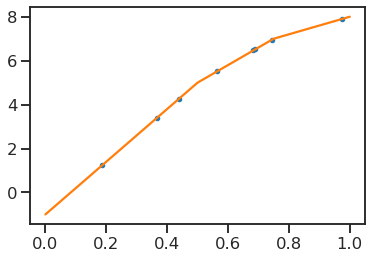

In [110]:
plt.plot(sample_age.tag.test_value,gia_model.tag.test_value,'.')
plt.plot(TIME,GIA)

In [118]:
from pymc3.distributions.dist_math import SplineWrapper
with pm.Model():
    test=Interpolated('test',TIME,GIA)
    d = pm.Deterministic('d',test(.5))

TypeError: 'TransformedRV' object is not callable

In [119]:
from pymc3.distributions.dist_math import SplineWrapper